# SMM with Monte Carlo

## Python Imports

In [1]:
import numpy as np
import random
from scipy.stats import pearsonr
import matplotlib.pyplot as plt

%matplotlib inline

## Data Imports

## DEFINE THE PATH TO YOUR COURSE DIRECTORY

In [2]:
data_dir = "/Users/mblanco/Desktop/DTU/AlgorithmsInBioinf/data/"

## Define run time parameters

In [3]:
# temperature vector
T_i = 0.01
T_f = 0.000001
T_steps = 10
T_delta = (T_f - T_i) / T_steps
T = np.linspace(T_i,T_f,T_steps )

# iterations
iters = 1000

# regularization lambda
lamb = 1
#lamb = 0.00001
#lamb = 10

### Training Data

In [4]:
training_file = data_dir + "SMM/A0201_training"
#training_file = data_dir + "SMM/A2403_training"
training = np.loadtxt(training_file, dtype=str)

### Evaluation Data

In [5]:
evaluation_file = data_dir + "SMM/A0201_evaluation"
#evaluation_file = data_dir + "SMM/A2403_evaluation"
evaluation = np.loadtxt(evaluation_file, dtype=str)

### Alphabet

In [6]:
alphabet_file = data_dir + "Matrices/alphabet"
alphabet = np.loadtxt(alphabet_file, dtype=str)

### Sparse Encoding Scheme

In [7]:
sparse_file = data_dir + "Matrices/sparse"
_sparse = np.loadtxt(sparse_file, dtype=float)
sparse = {}

for i, letter_1 in enumerate(alphabet):
    
    sparse[letter_1] = {}

    for j, letter_2 in enumerate(alphabet):
        
        sparse[letter_1][letter_2] = _sparse[i, j]

## Peptide Encoding

In [8]:
def encode(peptides, encoding_scheme, alphabet):
    
    encoded_peptides = []

    for peptide in peptides:

        encoded_peptide = []

        for peptide_letter in peptide:

            for alphabet_letter in alphabet:

                encoded_peptide.append(encoding_scheme[peptide_letter][alphabet_letter])

        encoded_peptides.append(encoded_peptide)
        
    return np.array(encoded_peptides)

## Error Function

In [9]:
def cumulative_error(peptides, y, lamb, weights):

    error = 0
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]

        # get target prediction value
        y_target = y[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
            
        # calculate error
        error += 1.0/2 * (y_pred - y_target)**2 
        
    gerror = error + lamb*np.dot(weights, weights)
    error /= len(peptides)
        
    return gerror, error

## Predict value for a peptide list

In [10]:
def predict(peptides, weights):

    pred = []
    
    for i in range(0, len(peptides)):
        
        # get peptide
        peptide = peptides[i]
        
        # get prediction
        y_pred = np.dot(peptide, weights)
        
        pred.append(y_pred)
        
    return pred

## Calculate MSE between two vectors

In [11]:
def cal_mse(vec1, vec2):
    
    mse = 0
    
    for i in range(0, len(vec1)):
        mse += (vec1[i] - vec2[i])**2
        
    mse /= len(vec1)
    
    return( mse)
    

## Main Loop

In [15]:
# Random seed
np.random.seed( 1 )

# peptides
peptides = training[:, 0]
peptides = encode(peptides, sparse, alphabet)

# target values
y = np.array(training[:, 1], dtype=float)

#evaluation peptides
evaluation_peptides = evaluation[:, 0]
evaluation_peptides = encode(evaluation_peptides, sparse, alphabet)

#evaluation targets
evaluation_targets = np.array(evaluation[:, 1], dtype=float)

# weights
input_dim  = len(peptides[0])
output_dim = 1
w_bound = 0.1
weights = np.random.uniform(-w_bound, w_bound, size=input_dim)

# error plots
gerror_plot = []
mse_plot = []
train_mse_plot = []
eval_mse_plot = []
train_pcc_plot = []
eval_pcc_plot = []

perturbation_value = 0.1
# The scale variable defines the scale of the changes in de. This is defined empirically for each problem investigated
scale = 1.0/100

number_of_tries = 0
number_of_accepted = 0
        
# calculate initial error
gerror_initial, mse = cumulative_error(peptides, y, lamb, weights)
        
# for each temperature
for t in T:
  
    # for each iteration
    for i in range(0, iters):
        
        
        # get 2 random weight indexes
        weight_index_1 = np.random.randint(len(weights))
        weight_index_2 = np.random.randint(len(weights))
    
        # ensure they are different
        while weight_index_1 == weight_index_2:
            weight_index_2 = np.random.randint(len(weights))
        
        # store original weight values
        original_weight_1 = weights[weight_index_1]
        original_weight_2 = weights[weight_index_2]
       
    
        # apply random perturbation to both weights
        perturbation = np.random.uniform(0, perturbation_value)
        weights[weight_index_1] +=  perturbation
        weights[weight_index_2] -=  perturbation
            
            
        # calculate new error
        gerror_new, mse = cumulative_error(peptides, y, lamb, weights) 
            
        # compute error difference
        de = (gerror_new - gerror_initial) * scale

        # compute acceptance probability
        if ( de < 0): 
            p = 1
        else:
            p = np.exp(-de/t)   #-de if we want to minimize, de if we want to maximize
            
        # throw coin
        coin = np.random.uniform(0.0, 1.0, 1)[0] 
        
        # weight change is accepted
        if ( coin < p ):
            gerror_initial = gerror_new
            gerror_plot.append(gerror_new)
            mse_plot.append(mse)
            number_of_accepted += 1
        # weight change is declined, restore previous weights
        else: 
            weights[weight_index_1] = original_weight_1 
            weights[weight_index_2] = original_weight_2

        number_of_tries += 1
        
        # define size of move so that on avarage 50% are accepted
        if number_of_tries == 100:
            
            if float(number_of_accepted)/number_of_tries > 0.5:
                perturbation_value *= 1.1
            else: 
                perturbation_value *= 0.9
            
            number_of_tries = 0
            number_of_accepted = 0
            
        # predict on training data
        train_pred = predict(peptides, weights)
        train_mse = cal_mse(y, train_pred)
        train_pcc = pearsonr(y, train_pred)[0]
        train_mse_plot.append(train_mse)
        train_pcc_plot.append(train_pcc)
        
        # predict on evaluation data
        eval_pred = predict(evaluation_peptides, weights)
        eval_mse = cal_mse(evaluation_targets, eval_pred)
        eval_pcc = pearsonr(evaluation_targets, eval_pred)[0]
        eval_mse_plot.append(eval_mse)
        eval_pcc_plot.append(eval_pcc)    
        
    print("t:", t, "gerror: ", round(gerror_new, 4), "Perturbation Value: ", round(perturbation_value, 4), "train MSE: ", round(train_mse, 4), "train pcc: ", round(train_pcc, 4), "eval MSE:", round(eval_mse, 4),"eval PCC: " ,round(eval_pcc, 4))

t: 0.01 gerror:  141.559 Perturbation Value:  0.1736 train MSE:  0.1111 train pcc:  0.5383 eval MSE: 0.129 eval PCC:  0.505
t: 0.008889000000000001 gerror:  112.0545 Perturbation Value:  0.2018 train MSE:  0.0871 train pcc:  0.6032 eval MSE: 0.1025 eval PCC:  0.5795
t: 0.007778 gerror:  111.1593 Perturbation Value:  0.157 train MSE:  0.0864 train pcc:  0.6029 eval MSE: 0.0946 eval PCC:  0.586
t: 0.006667 gerror:  91.4539 Perturbation Value:  0.1493 train MSE:  0.0684 train pcc:  0.6745 eval MSE: 0.0805 eval PCC:  0.647
t: 0.005556 gerror:  96.9786 Perturbation Value:  0.142 train MSE:  0.0736 train pcc:  0.6582 eval MSE: 0.0863 eval PCC:  0.6147
t: 0.004445 gerror:  82.2448 Perturbation Value:  0.1351 train MSE:  0.0634 train pcc:  0.6759 eval MSE: 0.0764 eval PCC:  0.6441
t: 0.003334 gerror:  66.438 Perturbation Value:  0.1051 train MSE:  0.0506 train pcc:  0.7373 eval MSE: 0.0575 eval PCC:  0.7077
t: 0.002223 gerror:  58.5434 Perturbation Value:  0.0999 train MSE:  0.0448 train pcc: 

## Error Plot

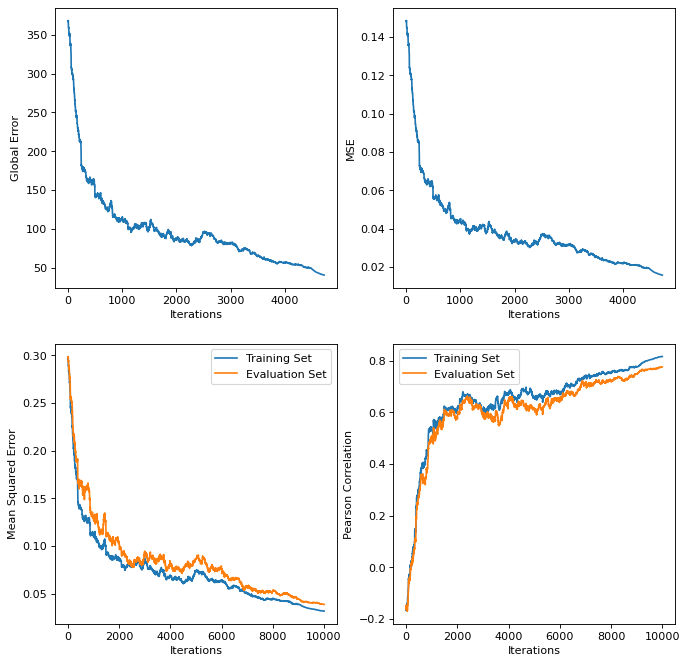

In [16]:
fig = plt.figure(figsize=(10, 10), dpi= 80)

x = np.arange(0, len(gerror_plot))

plt.subplot(2, 2, 1)
plt.plot(x, gerror_plot)
plt.ylabel("Global Error", fontsize=10);
plt.xlabel("Iterations", fontsize=10);

plt.subplot(2, 2, 2)
plt.plot(x, mse_plot)
plt.ylabel("MSE", fontsize=10);
plt.xlabel("Iterations", fontsize=10);


x = np.arange(0, len(train_mse_plot))

plt.subplot(2, 2, 3)
plt.plot(x, train_mse_plot, label="Training Set")
plt.plot(x, eval_mse_plot, label="Evaluation Set")
plt.ylabel("Mean Squared Error", fontsize=10);
plt.xlabel("Iterations", fontsize=10);
plt.legend(loc='upper right');


plt.subplot(2, 2, 4)
plt.plot(x, train_pcc_plot, label="Training Set")
plt.plot(x, eval_pcc_plot, label="Evaluation Set")
plt.ylabel("Pearson Correlation", fontsize=10);
plt.xlabel("Iterations", fontsize=10);
plt.legend(loc='upper left');

## Get PSSM Matrix

### Vector to Matrix

In [17]:
# our matrices are vectors of dictionaries
def vector_to_matrix(vector, alphabet):
    
    rows = int(len(vector)/len(alphabet))
    
    matrix = [0] * rows
    
    offset = 0
    
    for i in range(0, rows):
        
        matrix[i] = {}
        
        for j in range(0, 20):
            
            matrix[i][alphabet[j]] = vector[j+offset] 
        
        offset += len(alphabet)

    return matrix

### Matrix to Psi-Blast



In [18]:
def to_psi_blast(matrix):

    # print to user
    
    header = ["", "A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*header)) 

    letter_order = ["A", "R", "N", "D", "C", "Q", "E", "G", "H", "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]

    for i, row in enumerate(matrix):

        scores = []

        scores.append(str(i+1) + " A")

        for letter in letter_order:

            score = row[letter]

            scores.append(round(score, 4))

        print('{:>4} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8} {:>8}'.format(*scores)) 

### Print

In [19]:
matrix = vector_to_matrix(weights, alphabet)
to_psi_blast(matrix)

            A        R        N        D        C        Q        E        G        H        I        L        K        M        F        P        S        T        W        Y        V
 1 A  -0.0185   0.0125  -0.0631  -0.2039  -0.0389  -0.0822  -0.1449  -0.0575  -0.0914  -0.0179   0.0016    0.027   0.0707   0.1603   -0.213  -0.0212  -0.0554  -0.0648   0.1089  -0.0201
 2 A   0.1325   0.1087   0.0021  -0.2487  -0.0415   0.2137   0.0885  -0.0996   0.0231   0.2458   0.3839  -0.1658   0.3953   0.1402   0.0263   0.1684   0.1665  -0.0414   0.1172   0.1994
 3 A   0.0038  -0.1078  -0.0356   0.0194  -0.0319   -0.065  -0.1358  -0.0844  -0.0349   0.0371   0.0307   -0.182   0.1404   0.0487  -0.0499    0.007  -0.0782  -0.0275   0.0389  -0.0619
 4 A   0.0262  -0.0132  -0.0169   0.1022  -0.0226   0.0048   0.0765   0.0419  -0.0168  -0.0023  -0.0337     0.04   0.0318   0.0429   0.0219   0.0343     0.04   0.1013   0.0265   -0.005
 5 A  -0.0392  -0.0245  -0.0697  -0.0093  -0.0358  -0.0741  -0.0132  -0.031

## Performance Evaluation

In [20]:
evaluation_peptides = evaluation[:, 0]
evaluation_peptides = np.array(encode(evaluation_peptides, sparse, alphabet))

evaluation_targets = np.array(evaluation[:, 1], dtype=float)

y_pred = []
for i in range(0, len(evaluation_peptides)): 
    y_pred.append(np.dot(evaluation_peptides[i], weights))
    
y_pred = np.array(y_pred)

PCC:  0.775826259336268


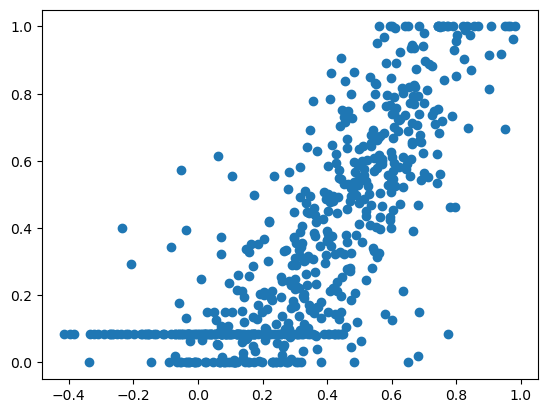

In [21]:
pcc = pearsonr(evaluation_targets, np.array(y_pred))
print("PCC: ", pcc[0])
plt.scatter(y_pred, evaluation_targets);